In [1]:
import os
import re
import sys
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
from math import ceil
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from IPython.display import FileLink

In [2]:
DATA_PATH = r'C:\Users\Mobile Programming\Desktop\APTOS'

TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train_images')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test_images')
TRAIN_LABEL_PATH = os.path.join(DATA_PATH, 'train.csv')
TEST_LABEL_PATH = os.path.join(DATA_PATH, 'test.csv')

df_train = pd.read_csv(TRAIN_LABEL_PATH)
df_test = pd.read_csv(TEST_LABEL_PATH)

print('num of train images ', len(os.listdir(TRAIN_IMG_PATH)))
print('num of test images  ', len(os.listdir(TEST_IMG_PATH)))

num of train images  3663
num of test images   1929


In [3]:
# Convert 'diagnosis' column to string type
df_train['diagnosis'] = df_train['diagnosis'].astype(str)

# Append '.png' extension to 'id_code' if not already present
df_train['id_code'] = df_train['id_code'].apply(lambda x: x + '.png' if x.split('.')[-1] != 'png' else x)
df_test['id_code'] = df_test['id_code'].apply(lambda x: x + '.png' if x.split('.')[-1] != 'png' else x)

# Split the training data into training and validation sets
train_data = np.arange(df_train.shape[0])
train_idx, val_idx = train_test_split(train_data, train_size=0.85, random_state=2019)

X_train = df_train.iloc[train_idx, :]
X_val = df_train.iloc[val_idx, :]
X_test = df_test

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3112, 2)
(550, 2)
(1928, 1)


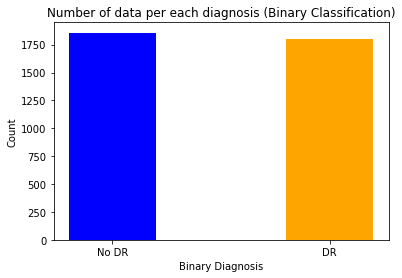

In [4]:
# Map all classes other than "No DR" to 1
df_train['binary_diagnosis'] = df_train['diagnosis'].apply(lambda x: '1' if x != '0' else x)

# Calculate the counts of each diagnosis category (including the binary labels)
diagnosis_counts = df_train['binary_diagnosis'].value_counts()

# Set the figure size
plt.figure(figsize=(6, 4))

# Create a bar plot
plt.bar(diagnosis_counts.index, diagnosis_counts.values, align='center', width=0.4, color=['blue', 'orange'])

# Set labels and title
plt.xlabel('Binary Diagnosis')
plt.ylabel('Count')
plt.title('Number of data per each diagnosis (Binary Classification)')

# Set the x-axis ticks
plt.xticks(range(len(diagnosis_counts.index)), ['No DR', 'DR'])

# Show the plot
plt.show()


In [5]:
# Map all classes other than "No DR" to 1
X_train['diagnosis'] = X_train['diagnosis'].apply(lambda x: '1' if x != '0' else x)
X_val['diagnosis'] = X_val['diagnosis'].apply(lambda x: '1' if x != '0' else x)

# Convert 'diagnosis' column to string type
X_train['diagnosis'] = X_train['diagnosis'].astype(str)
X_val['diagnosis'] = X_val['diagnosis'].astype(str)


C:\Users\Mobile Programming\anaconda3_1\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Mobile Programming\anaconda3_1\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Mobile Programming\anaconda3_1\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is try

In [14]:
print(X_val['diagnosis'].unique())


['0' '1']


In [6]:
num_classes_binary = 2
img_size = (299, 299, 3)
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(X_test)
epochs = 10
batch_size = 32

train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    rescale=1./255
)
val_datagen = ImageDataGenerator(
    rescale=1./255
)
# Apply TTA
test_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    rescale=1./255
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory=TRAIN_IMG_PATH,
    x_col='id_code',
    y_col='diagnosis',
    target_size=img_size[:2],
    color_mode='rgb',
    class_mode='binary',  # Change this to binary
    batch_size=batch_size,
    seed=2019
)
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=X_val,
    directory=TRAIN_IMG_PATH,
    x_col='id_code',
    y_col='diagnosis',
    target_size=img_size[:2],
    color_mode='rgb',
    class_mode='binary',  # Make sure this is set to binary
    batch_size=batch_size,
    shuffle=False,  # Ensure no shuffling for validation
    seed=2019
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=X_test,
    directory=TEST_IMG_PATH,
    x_col='id_code',
    y_col=None,
    target_size= img_size[:2],
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle=False,
    seed=2019
)

Found 3112 validated image filenames belonging to 2 classes.
Found 550 validated image filenames belonging to 2 classes.
Found 1928 validated image filenames.


In [7]:
def get_model(model_type, input_shape, num_classes):
    input_tensor = Input(shape=input_shape)
    if model_type == 'InceptionV3':
        base_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_tensor)
    #elif model_type == 'Xception':
        #base_model = Xception(include_top=False, weights='imagenet', input_tensor=input_tensor)
    else:
        print("Invalid model_type; defaulting to InceptionV3")
        base_model = InceptionV3(include_top=False, weights=None, input_tensor=input_tensor)
        base_model.load_weights(filepath=file_path)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_tensor = Dense(1, activation='sigmoid')(x)  # Change num_classes to 1


    model = Model(inputs=input_tensor, outputs=output_tensor)

    optimizer = RMSprop(learning_rate=1e-4)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [27]:
LOG_DIR = './logs'
if not os.path.isdir(LOG_DIR):
    os.mkdir(LOG_DIR)
else:
    pass

In [8]:
# Define the input shape and number of classes for your specific problem
input_shape = (299, 299, 3)  # for example, if you're using 299x299 RGB images
num_classes = 2  # replace with the actual number of classes (binary classification)

# Instantiate the model
model_inception = get_model('InceptionV3', input_shape, num_classes)


In [30]:
# Define the input shape and number of classes for your specific problem
input_shape = (299, 299, 3)  # for example, if you're using 299x299 RGB images
num_classes = 2  # replace with the actual number of classes (binary classification)

# Instantiate the model
model_inception = get_model('InceptionV3', input_shape, num_classes)

# Inception Model
CKPT_PATH_INCEPTION = LOG_DIR + '/inception_best_model_two.hdf5'
checkPoint_inception = ModelCheckpoint(filepath=CKPT_PATH_INCEPTION, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduceLROnPlateau_inception = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0000001, verbose=1, mode='min')
earlyStopping_inception = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

# Train the model
history_inception = model_inception.fit(
    train_generator,
    steps_per_epoch=ceil(nb_train_samples / batch_size),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=ceil(nb_validation_samples / batch_size),
    callbacks=[reduceLROnPlateau_inception, earlyStopping_inception],
    verbose=1
)
# checkPoint_inception,


Epoch 1/10
98/98 [==============================] - 1449s 15s/step - loss: 0.2438 - accuracy: 0.8975 - val_loss: 0.3653 - val_accuracy: 0.9309
Epoch 2/10
98/98 [==============================] - 1336s 14s/step - loss: 0.0960 - accuracy: 0.9701 - val_loss: 0.1622 - val_accuracy: 0.9709
Epoch 3/10
98/98 [==============================] - 1352s 14s/step - loss: 0.0588 - accuracy: 0.9810 - val_loss: 0.5083 - val_accuracy: 0.9418
Epoch 4/10
98/98 [==============================] - 1367s 14s/step - loss: 0.0636 - accuracy: 0.9823 - val_loss: 0.3022 - val_accuracy: 0.9691

Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 5/10
98/98 [==============================] - 1376s 14s/step - loss: 0.0379 - accuracy: 0.9879 - val_loss: 0.1035 - val_accuracy: 0.9782
Epoch 6/10
98/98 [==============================] - 1347s 14s/step - loss: 0.0349 - accuracy: 0.9876 - val_loss: 0.0787 - val_accuracy: 0.9818
Epoch 7/10
98/98 [==============================] - 1348s 14s

In [9]:
model_inception.save("DR_twoclass.hdf5")

In [15]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import streamlit as st


@st.cache(allow_output_mutation=True)
def load_model():
  model_inception=tf.keras.models.load_model("DR_twoclass.hdf5")
  return model
with st.spinner('Model is being loaded..'):
  model_inception=load_model()

st.write("""
         # Flower Classification
         """
         )

file = st.file_uploader("Please upload an brain scan file", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model_inception):
    
        size = (299,299)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.
        
        img_reshape = img[np.newaxis,...]
    
        prediction = model_inception.predict(img_reshape)
        
        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model_inception)
    score = tf.nn.softmax(predictions[0])
    st.write(prediction)
    st.write(score)
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)



Overwriting app.py


In [16]:
!ngrok authtoken AV6655JTUCY2YTMJ4465MLRUG6TTJZEO

Authtoken saved to configuration file: C:\Users\Mobile Programming\AppData\Local/ngrok/ngrok.yml


In [33]:
# Examine the model predictions and actual labels on the validation set
predictions = model_inception.predict(validation_generator)
predicted_labels = (predictions > 0.5).astype(int)  # Assuming a threshold of 0.5 for binary classification

# Display the predicted labels and actual labels side by side
result_df = pd.DataFrame({'Actual': validation_generator.classes, 'Predicted': predicted_labels.flatten()})
print(result_df.head())


   Actual  Predicted
0       0          0
1       0          0
2       1          1
3       1          1
4       1          1


In [34]:
from sklearn.metrics import classification_report

print(classification_report(validation_generator.classes, predicted_labels))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       286
           1       0.98      0.98      0.98       264

    accuracy                           0.98       550
   macro avg       0.98      0.98      0.98       550
weighted avg       0.98      0.98      0.98       550



In [19]:
#LOG_DIR = './logs'
#if not os.path.isdir(LOG_DIR):
#    os.mkdir(LOG_DIR)
#else:
#    pass

In [35]:
# Extracting training and validation accuracy from the history
train_accuracy = history_inception.history['accuracy']
val_accuracy = history_inception.history['val_accuracy']

# Print the overall accuracy and validation accuracy
accuracy = train_accuracy[-1]
validation_accuracy = val_accuracy[-1]

print(f"Accuracy: {accuracy}")
print(f"Validation Accuracy: {validation_accuracy}")

Accuracy: 0.990359902381897
Validation Accuracy: 0.9818181991577148


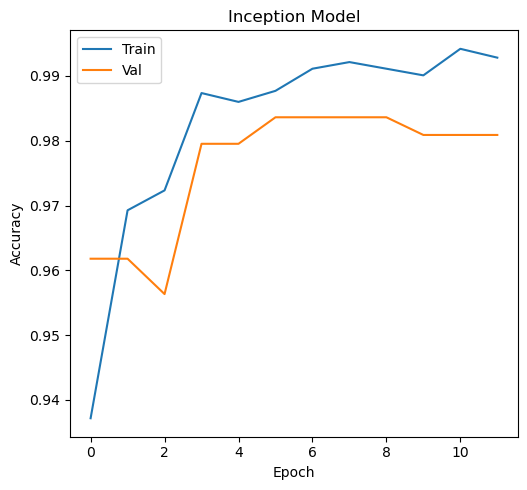

In [30]:
# For Inception model
acc_inception = history_inception.history['accuracy']
val_acc_inception = history_inception.history['val_accuracy']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc_inception)
plt.plot(val_acc_inception)
plt.title('Inception Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()


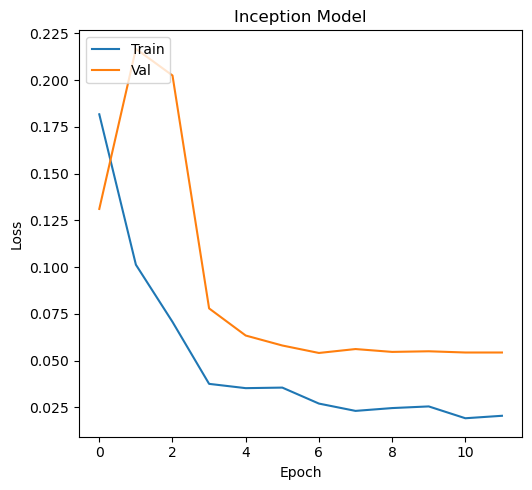

In [31]:
# Inception Model
loss_inception = history_inception.history['loss']
val_loss_inception = history_inception.history['val_loss']

# Xception Model
#loss_xception = history_xception.history['loss']
#val_loss_xception = history_xception.history['val_loss']

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot for Inception Model
plt.subplot(1, 2, 1)
plt.plot(loss_inception)
plt.plot(val_loss_inception)
plt.title('Inception Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [42]:
import os
from tensorflow.keras.models import load_model


In [43]:
# Save the trained model
model_inception.save(r'C:\Users\Mobile Programming\Desktop\binary_dr_wgt_model.hdf5')


In [44]:


# Load the saved model
loaded_model = load_model(r'C:\Users\Mobile Programming\Desktop\binary_dr_wgt_model.hdf5')


In [45]:
loaded_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_658 (Conv2D)             (None, 149, 149, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_658 (BatchN (None, 149, 149, 32) 96          conv2d_658[0][0]                 
__________________________________________________________________________________________________
activation_658 (Activation)     (None, 149, 149, 32) 0           batch_normalization_658[0][0]    
____________________________________________________________________________________________

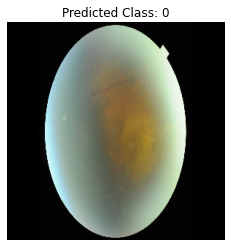

Predicted Class: 0


In [56]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np

# Load the saved model
model_inception = load_model(r'C:\Users\Mobile Programming\Desktop\binary_dr_wgt_model.hdf5') 

# Load the image
img_path = r'C:\Users\Mobile Programming\Desktop\11.png'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Normalize the image data

# Make prediction
prediction = model_inception.predict(x)
predicted_class = int(round(prediction[0][0]))  # Round the probability to 0 or 1

# Display the image
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')  # Remove axis labels
plt.title(f'Predicted Class: {predicted_class}')
plt.show()

# Print the predicted class
print("Predicted Class:", predicted_class)
